Importing basic Libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import collections
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
sns.set(font_scale=1.3)
import datetime
import wordcloud
from wordcloud import WordCloud, STOPWORDS 

Considering the Cleaned Data So no pre processing wilbe required

In [2]:
df_tweets = pd.read_csv("Compiled & Processed Data_1.csv",encoding = "ISO-8859-1")

In [3]:
df_tweets.head(5)

,Id,Timestamp,Source,Retwwet_Count,User_Name,tweets,text_length
0,1.250000e+18,06/04/20 4:27,Twitter for iPhone,0,Bradley Belmore,would rather vulnerable americans hate pres...,29
1,1.250000e+18,06/04/20 4:27,SocialFlow,0,FT Emerging Markets,emerge market possible tariff,5
2,1.250000e+18,06/04/20 4:27,Twitter for iPhone,0,Griffin,they praise nation action lack action alread...,24
3,1.250000e+18,06/04/20 4:27,Paper.li,0,Al Meyers,late meyers daily thanks trump covid,9
4,1.250000e+18,06/04/20 4:27,Twitter Web Client,0,Elizabeth Pendleton,trump kill supporter even white house insi...,14


In [4]:
df_tweets.shape

(6497, 7)

In [5]:
import nltk
#nltk.download('book')
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

In [6]:
df_tweets["tweets"] = df_tweets['tweets'].str.replace(r'\b\w{15,3000}\b', r' ')
df_tweets["tweets"] = df_tweets['tweets'].str.replace('sababun', '')

In [7]:
#! pip install pySpellChecker

In [8]:
from spellchecker import SpellChecker

spell = SpellChecker()

In [9]:
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)

#df_tweets["tweets"] = df_tweets["tweets"].apply(lambda text: correct_spellings(text))

In [10]:
df_tweets.shape

(6497, 7)

In [11]:
from collections import Counter
cnt = Counter()
for text in df_tweets['tweets'].values:
    for word in text.split():
        cnt[word] += 1
cnt.most_common(20)

[('covid', 1243),
 ('test', 618),
 ('coronavirus', 588),
 ('case', 445),
 ('death', 411),
 ('take', 362),
 ('know', 358),
 ('pandemic', 314),
 ('positive', 313),
 ('need', 310),
 ('work', 308),
 ('make', 300),
 ('trump', 293),
 ('patient', 284),
 ('india', 270),
 ('help', 260),
 ('would', 258),
 ('think', 238),
 ('fight', 231),
 ('good', 211)]

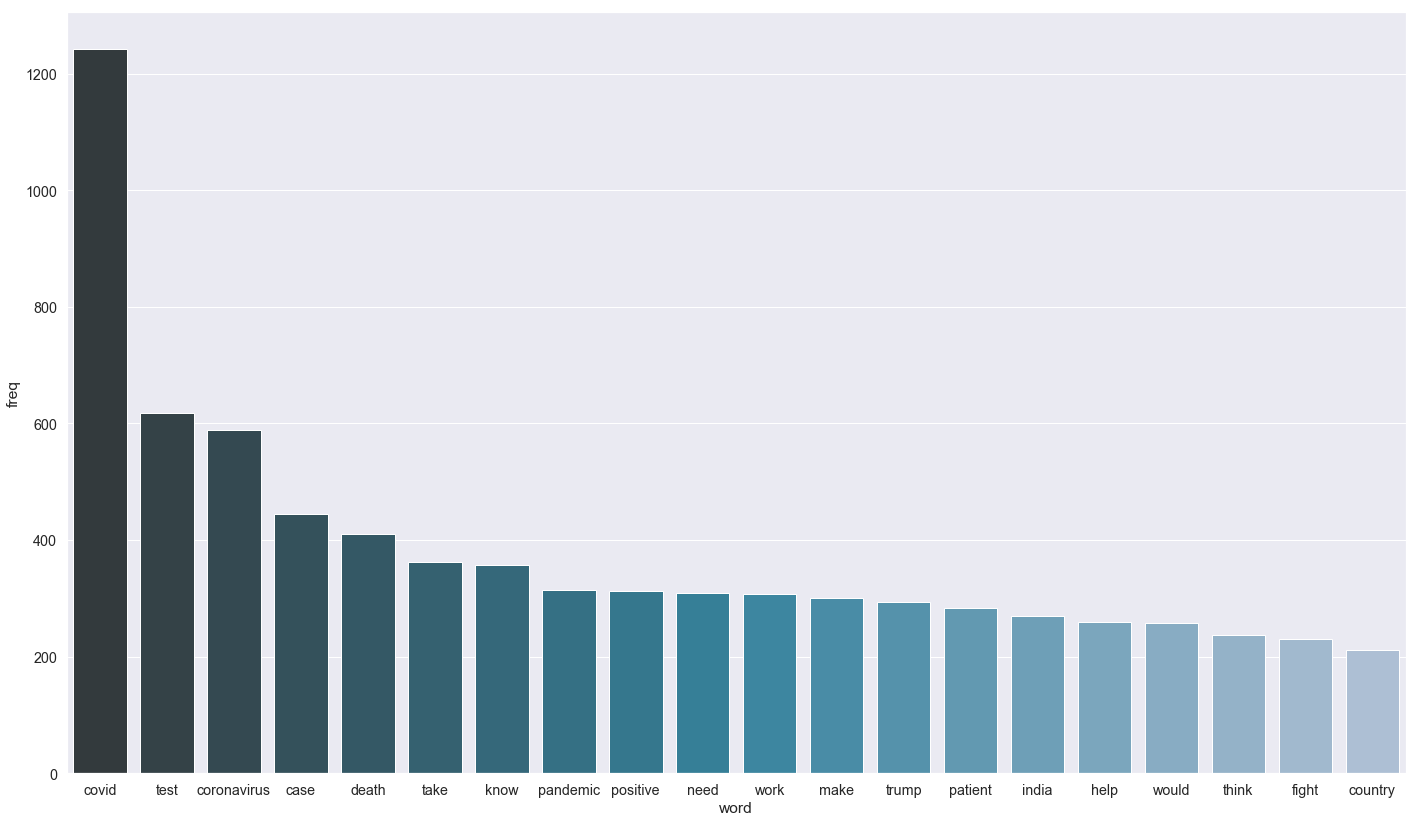

In [12]:
sr_clean= df_tweets['tweets']
cv = CountVectorizer()
bow = cv.fit_transform(sr_clean)
word_freq = dict(zip(cv.get_feature_names(), np.asarray(bow.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)

word_counter_df = pd.DataFrame(word_counter.most_common(20), columns = ['word', 'freq'])
fig, ax = plt.subplots(figsize=(24, 14))
sns.barplot(x= "word", y="freq", data=word_counter_df, palette="PuBuGn_d", ax=ax)
plt.show();

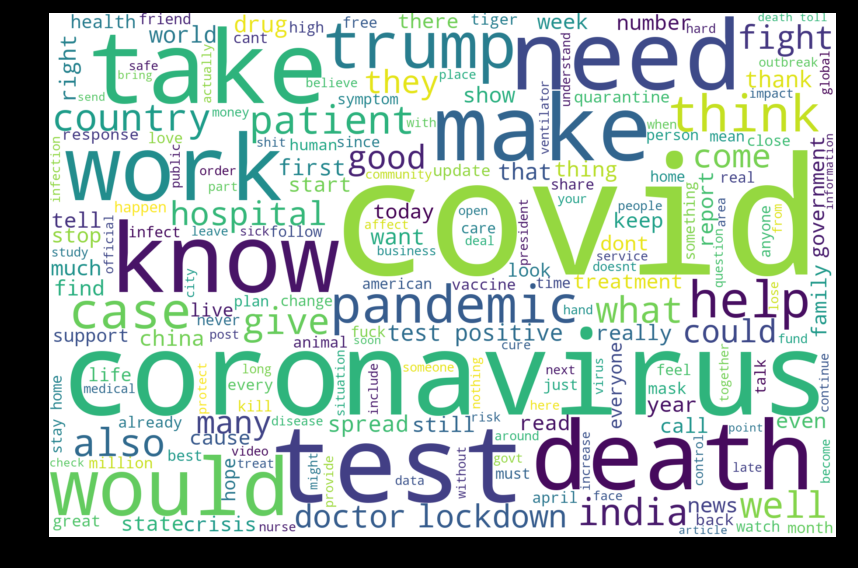

In [13]:
# Word Cloud

lemmatizer = WordNetLemmatizer()
wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}
def lemmatize_words(text):
    pos_tagged_text = nltk.pos_tag(text)
    return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) 
    for word, pos in pos_tagged_text])

stopwords = lemmatize_words(df_tweets['tweets'])

comment_words = ' '

for val in df_tweets['tweets']: 
    val = str(val) 
    tokens = val.split() 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
      comment_words = comment_words + words + ' '

wordcloud = WordCloud(width = 1800, height = 1200, 
                background_color ='white', max_words = 200,
                stopwords = stopwords, 
                min_font_size = 8).generate(comment_words) 
                      
plt.figure(figsize = (12, 12), facecolor = 'black') 
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off') 
plt.tight_layout(pad = 1) 
  
plt.show() 

*** Networrk Graph

In [15]:
from nltk import bigrams
# Create list of lists containing bigrams in tweets
key_words = [text.lower().split() for text in df_tweets["tweets"] ]
terms_bigram = [list(bigrams(text)) for text in key_words]
terms_bigram[0]

[('would', 'rather'),
 ('rather', 'vulnerable'),
 ('vulnerable', 'americans'),
 ('americans', 'hate'),
 ('hate', 'president'),
 ('president', 'people'),
 ('people', 'make'),
 ('make', 'sick'),
 ('sick', 'regardless'),
 ('regardless', 'political'),
 ('political', 'affiliation'),
 ('affiliation', 'support'),
 ('support', 'especially'),
 ('especially', 'since'),
 ('since', 'safely'),
 ('safely', 'decade'),
 ('decade', 'already'),
 ('already', 'proven'),
 ('proven', 'effective')]

Network Graph using Top 30 Words

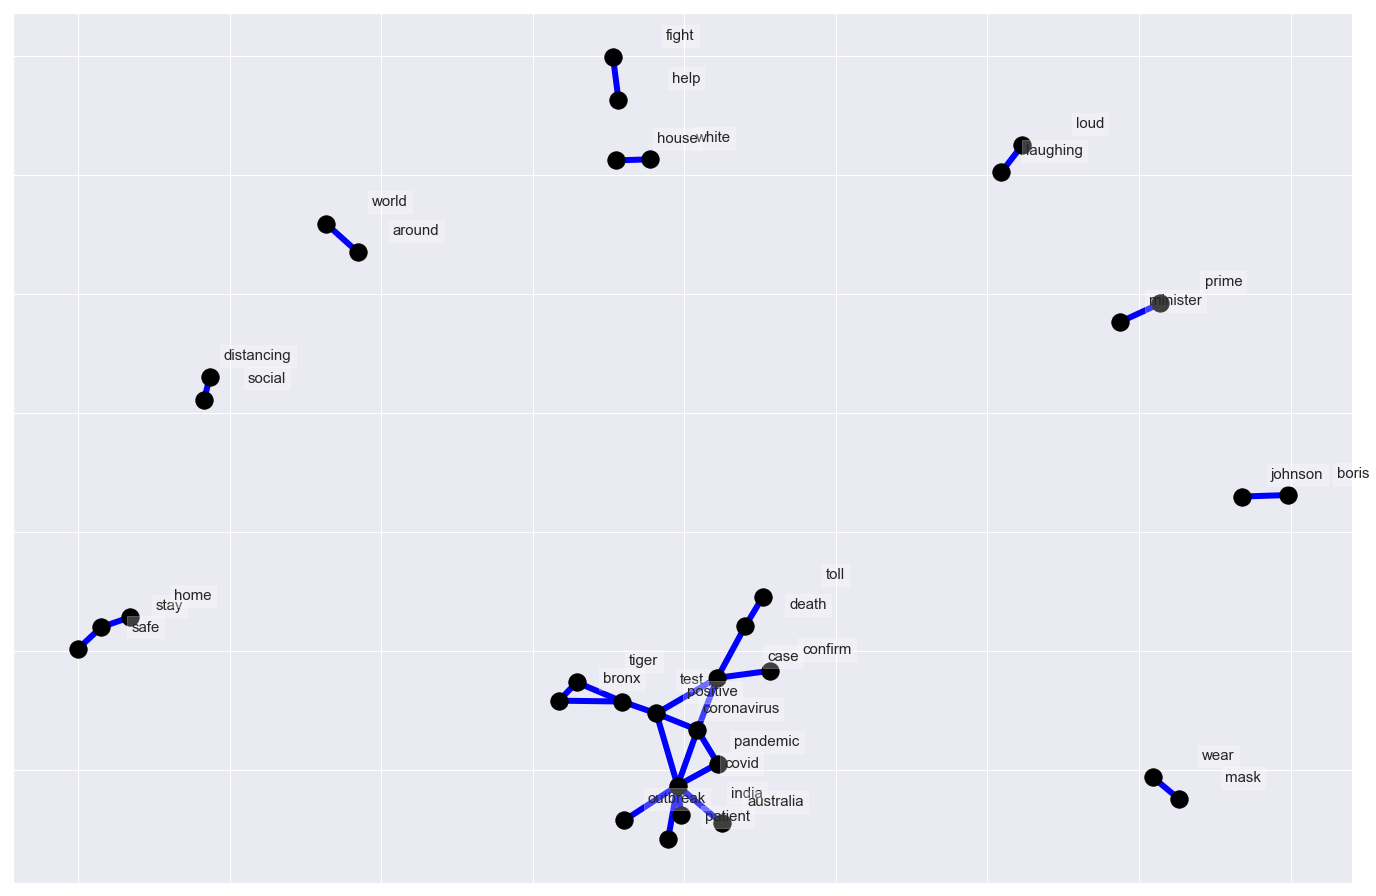

In [28]:
import itertools
bigrams = list(itertools.chain(*terms_bigram))
bigram_counts = collections.Counter(bigrams)

bigram_df = pd.DataFrame(bigram_counts.most_common(30),
                             columns=['bigram', 'count'])

import networkx as nx
d = bigram_df.set_index('bigram').T.to_dict('records')
G = nx.Graph()

for k, v in d[0].items():
    G.add_edge(k[0], k[1], weight=(v * 10))

fig, ax = plt.subplots(figsize=(24, 16))

pos = nx.spring_layout(G, k=1)

nx.draw_networkx(G, pos,
                 font_size=10,
                 width=6,
                 edge_color='blue',
                 node_color='black',
                 with_labels = False,
                 ax=ax)

for key, value in pos.items():
    x, y = value[0]+.135, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='white', alpha=0.25),
            horizontalalignment='right', 
            verticalalignment = 'center',
            fontsize=15)
    
plt.show()

In [29]:
import matplotlib.pyplot as pPlot
from wordcloud import WordCloud, STOPWORDS
import numpy as npy
from PIL import Image

In [30]:
def create_word_cloud(string):
    maskArray = npy.array(Image.open("cloud.png"))
    cloud = WordCloud(background_color = "white", max_words = 200, mask = maskArray, stopwords = set(STOPWORDS),
                     width = 400, height = 200)
    cloud.generate(string)
    cloud.to_file("covidcloud.png")

create_word_cloud(comment_words)

# Sentiment Classifier

In [31]:
import nltk
#nltk.download('vader_lexicon')
  
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

In [32]:
df_tweets['Sentiment_Scores'] = df_tweets['tweets'].apply(lambda x:sia.polarity_scores(x)['compound'])

In [33]:
df_tweets.head(5)

,Id,Timestamp,Source,Retwwet_Count,User_Name,tweets,text_length,Sentiment_Scores,Sentiment
0,1.250000e+18,06/04/20 4:27,Twitter for iPhone,0,Bradley Belmore,would rather vulnerable americans hate pres...,29,0.0972,Positive
1,1.250000e+18,06/04/20 4:27,SocialFlow,0,FT Emerging Markets,emerge market possible tariff,5,0.0000,Neutral
2,1.250000e+18,06/04/20 4:27,Twitter for iPhone,0,Griffin,they praise nation action lack action alread...,24,-0.3182,Negative
3,1.250000e+18,06/04/20 4:27,Paper.li,0,Al Meyers,late meyers daily thanks trump covid,9,0.4404,Positive
4,1.250000e+18,06/04/20 4:27,Twitter Web Client,0,Elizabeth Pendleton,trump kill supporter even white house insi...,14,-0.5574,Negative


In [34]:
df_tweets['Sentiment'] = df_tweets['Sentiment_Scores'].apply(lambda s : 
                                                             'Positive' if s > 0 else ('Negative' if s < 0 else 'Neutral'))

In [35]:
df_tweets.Sentiment.value_counts()

Positive    2728
Negative    2292
Neutral     1477
Name: Sentiment, dtype: int64

<BarContainer object of 3 artists>

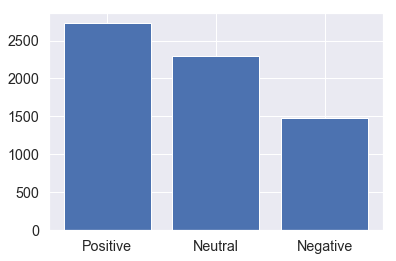

In [36]:
plt.bar(df_tweets.Sentiment.unique(), df_tweets.Sentiment.value_counts())

# Positive Words

In [41]:
# Word Cloud for POSITIVE Words

pos_data = df_tweets[df_tweets['Sentiment'] =='Positive'].copy()
stopwords = lemmatize_words(df_tweets['tweets'])

In [42]:
pos_data["tweets"] = pos_data['tweets'].str.replace('pandemic','')

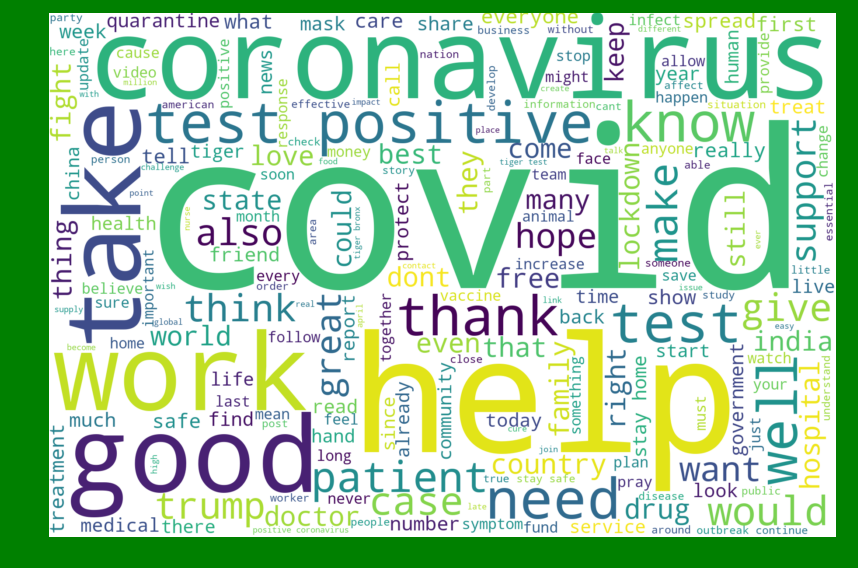

In [43]:
comment_words = ' '

for val in pos_data['tweets']: 
    val = str(val) 
    tokens = val.split() 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
      comment_words = comment_words + words + ' '

wordcloud = WordCloud(width = 1800, height = 1200, 
                background_color ='white', max_words = 200,
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
                      
plt.figure(figsize = (12, 12), facecolor = 'Green') 
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off') 
plt.tight_layout(pad = 1) 
  
plt.show() 

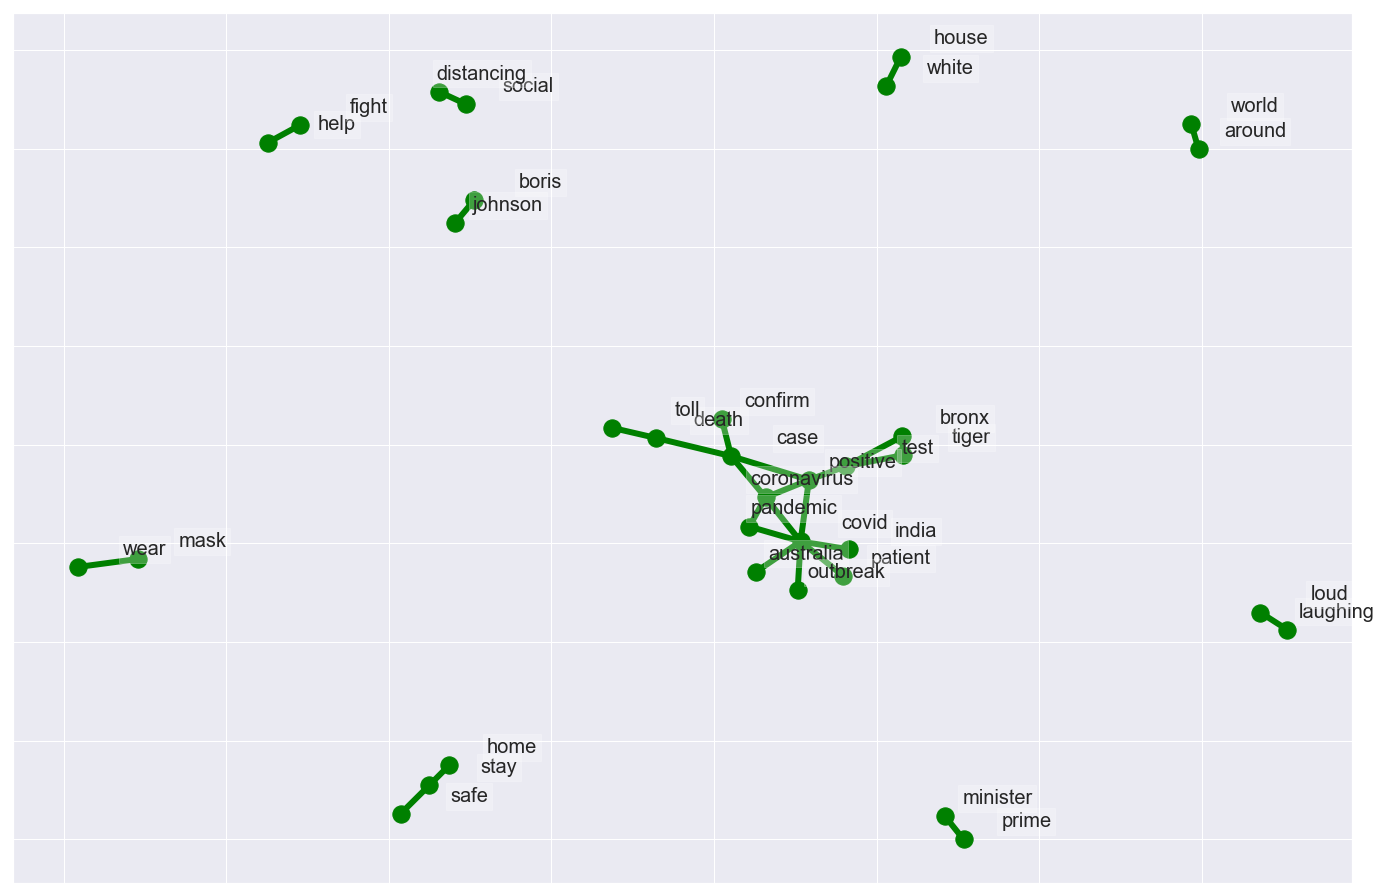

In [45]:
# For POSITIVE Words

from nltk import bigrams
# Create list of lists containing bigrams in tweets
key_words = [text.lower().split() for text in df_tweets.tweets]
terms_bigram = [list(bigrams(text)) for text in key_words]
terms_bigram[0]

bigrams = list(itertools.chain(*terms_bigram))
bigram_counts = collections.Counter(bigrams)

bigram_df = pd.DataFrame(bigram_counts.most_common(30),
                             columns=['bigram', 'count'])

import networkx as nx
d = bigram_df.set_index('bigram').T.to_dict('records')
G = nx.Graph()

for k, v in d[0].items():
    G.add_edge(k[0], k[1], weight=(v * 10))

fig, ax = plt.subplots(figsize=(24, 16))

pos = nx.spring_layout(G, k=1)

nx.draw_networkx(G, pos,
                 font_size=20,
                 width=6,
                 edge_color='green',
                 node_color='green',
                 with_labels = False,
                 ax=ax)

for key, value in pos.items():
    x, y = value[0]+.135, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='white', alpha=0.25),
            horizontalalignment='right', 
            verticalalignment = 'center',
            fontsize=20)
    
plt.show()

In [46]:
def create_word_cloud(string):
    maskArray = npy.array(Image.open("cloud.png"))
    cloud = WordCloud(background_color = "white", max_words = 200, mask = maskArray, stopwords = stopwords,
                     width = 400, height = 200)
    cloud.generate(string)
    cloud.to_file("positivecloud.png")

create_word_cloud(comment_words)

In [47]:
def create_word_cloud(string):
    maskArray = npy.array(Image.open("2.jpg"))
    cloud = WordCloud(background_color = "white", max_words = 200, mask = maskArray, stopwords = stopwords,
                     width = 400, height = 200)
    cloud.generate(string)
    cloud.to_file("positivecloud_2.png")

create_word_cloud(comment_words)

# Negative Words

In [48]:
# Word Cloud for NEGATIVE Words

neg_data = df_tweets[df_tweets['Sentiment'] =='Negative'].copy()
stopwords = lemmatize_words(df_tweets['tweets'])

In [49]:
neg_data["tweets"] = neg_data['tweets'].str.replace('fuck','')
neg_data["tweets"] = neg_data['tweets'].str.replace('fight','')
neg_data["tweets"] = neg_data['tweets'].str.replace('right','')
neg_data["tweets"] = neg_data['tweets'].str.replace('maruvaa','')
neg_data["tweets"] = neg_data['tweets'].str.replace('sababun','')
neg_data["tweets"] = neg_data['tweets'].str.replace('buldana','')
neg_data["tweets"] = neg_data['tweets'].str.replace('maharashtra','')
neg_data["tweets"] = neg_data['tweets'].str.replace('well','')

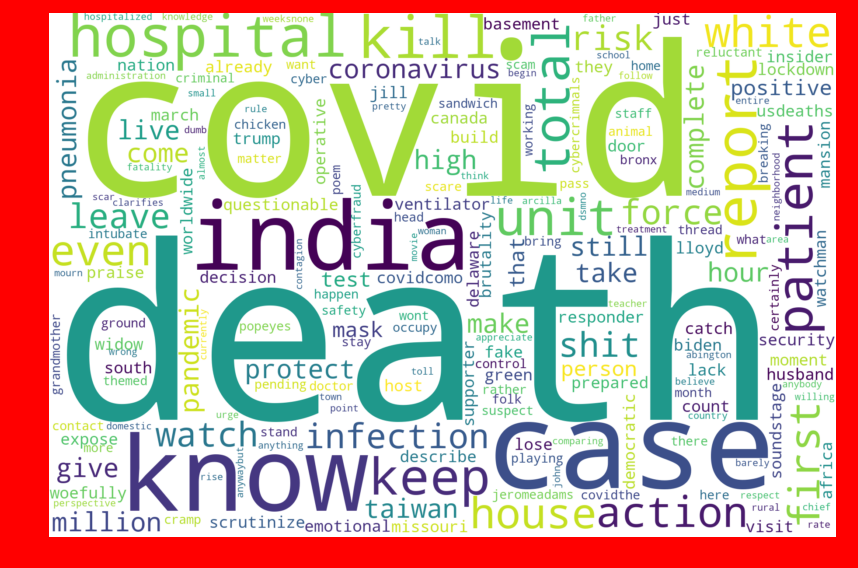

In [50]:
comment_words = ' '

for val in neg_data['tweets'][:30]: 
    val = str(val) 
    tokens = val.split() 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
      comment_words = comment_words + words + ' '

wordcloud = WordCloud(width = 1800, height = 1200, 
                background_color ='white', max_words = 200,
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
                      
plt.figure(figsize = (12, 12), facecolor = 'Red') 
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off') 
plt.tight_layout(pad = 1) 
  
plt.show() 

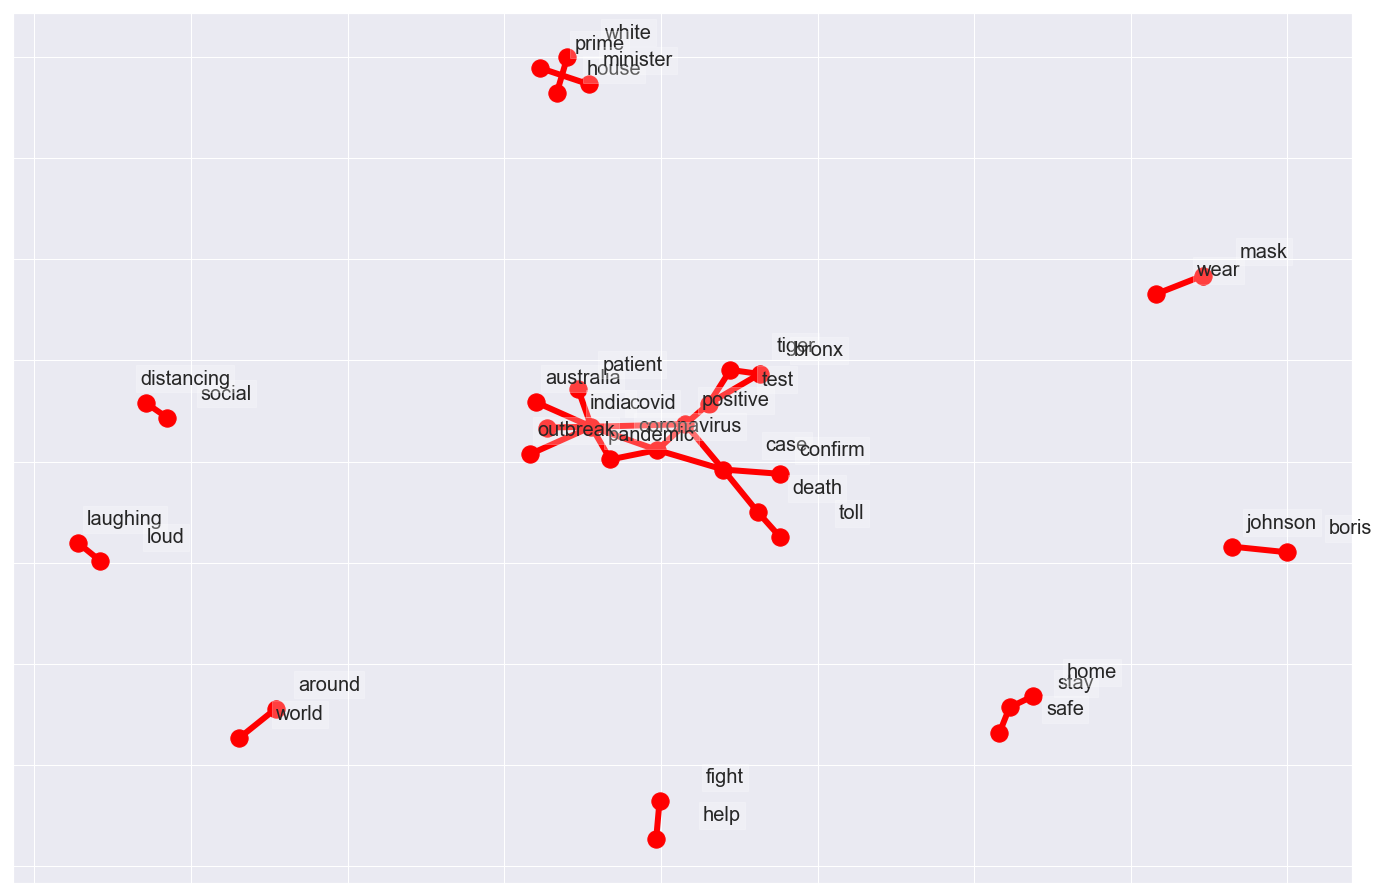

In [52]:
# For NEGATIVE Words

from nltk import bigrams
# Create list of lists containing bigrams in tweets
key_words = [text.lower().split() for text in df_tweets.tweets]
terms_bigram = [list(bigrams(text)) for text in key_words]
terms_bigram[0]

bigrams = list(itertools.chain(*terms_bigram))
bigram_counts = collections.Counter(bigrams)

bigram_df = pd.DataFrame(bigram_counts.most_common(30),
                             columns=['bigram', 'count'])

import networkx as nx
d = bigram_df.set_index('bigram').T.to_dict('records')
G = nx.Graph()

for k, v in d[0].items():
    G.add_edge(k[0], k[1], weight=(v * 10))

fig, ax = plt.subplots(figsize=(24, 16))

pos = nx.spring_layout(G, k=1)

nx.draw_networkx(G, pos,
                 font_size=20,
                 width=6,
                 edge_color='red',
                 node_color='red',
                 with_labels = False,
                 ax=ax)

for key, value in pos.items():
    x, y = value[0]+.135, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='white', alpha=0.25),
            horizontalalignment='right', 
            #verticalalignment = 'center',
            fontsize=20)
    
plt.show()

In [53]:
def create_word_cloud(string):
    maskArray = npy.array(Image.open("cloud.png"))
    cloud = WordCloud(background_color = "white", max_words = 200, mask = maskArray, stopwords = stopwords,
                      width = 400, height = 200)
    cloud.generate(string)
    cloud.to_file("negativecloud.png")

create_word_cloud(comment_words)

In [54]:
def create_word_cloud(string):
    maskArray = npy.array(Image.open("alice.png"))
    cloud = WordCloud(background_color = "white", max_words = 200, mask = maskArray, stopwords = stopwords,
                     width = 800, height = 400,contour_width=3, contour_color='steelblue')
    cloud.generate(string)
    cloud.to_file("negativecloud_2.png")

create_word_cloud(comment_words)

**************************  End ****************************